# 1. Import libraries

In [1]:
import numpy as np
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from datetime import timedelta

try:
    import holidays
except:
    !pip install holidays
    import holidays
try:
    import xgboost as xgb
except:
    !pip install xgboost
    import xgboost as xgb
try:
    from lunardate import LunarDate
except:
    !pip install lunardate
    from lunardate import LunarDate

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# 2. Load data

In [2]:
# Define url path to CSV
annex1 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex1.csv'
annex2 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex2.csv'
annex3 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex3.csv'
annex4 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex4.csv'

In [3]:
def get_df_from_url(url):
    # Create request response
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Create a file-like object from the raw content
        csv_content = StringIO(response.text)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_content)

        # Return DataFrame
        return df
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")

df_item = get_df_from_url(annex1)
df_transaction = get_df_from_url(annex2)
df_wholesale = get_df_from_url(annex3)
df_loss = get_df_from_url(annex4)

# 3. Merge and aggregate data

In [4]:
def merge_all_df(df_transaction: pd.DataFrame = df_transaction,
                 df_item: pd.DataFrame = df_item,
                 df_wholesale: pd.DataFrame = df_wholesale,
                 df_loss: pd.DataFrame = df_loss):

    df_merge = df_transaction.merge(df_item,
                                    how = 'left',
                                    on = 'Item Code')
    df_merge = df_merge.merge(df_wholesale,
                            how = 'left',
                            on = ['Date', 'Item Code'])
    df_merge = df_merge.merge(df_loss.drop('Item Name', axis = 1),
                            how = 'left',
                            on = 'Item Code')
    
    return df_merge

df_merge = merge_all_df()

In [5]:
# Create Sales column
df_merge['Sales'] = df_merge['Unit Selling Price (RMB/kg)'] * df_merge['Quantity Sold (kilo)']

# Aggregate as new table
df_agg = df_merge.groupby(['Date', 'Category Code', 'Item Code'], as_index = False)['Sales'].sum()
df_agg.head()

,Date,Category Code,Item Code,Sales
0,2020-07-01,1011010101,102900005115762,41.046
1,2020-07-01,1011010101,102900005115779,335.728
2,2020-07-01,1011010101,102900005115786,68.112
3,2020-07-01,1011010101,102900005115793,68.608
4,2020-07-01,1011010101,102900005115823,114.760


# 4. Feature Engineering

In [6]:
def create_date_feature(df: pd.DataFrame,
                       date_column: str):
    # Convert the 'Date' column to datetime type
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].astype('datetime64[ns]')

    # Extract date components
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday is 0 and Sunday is 6
    df['WeekNumber'] = df['Date'].dt.isocalendar().week
    df['Quarter'] = df['Date'].dt.quarter
    
    return df

def is_holiday(date_value):
    china_holidays = holidays.country_holidays('CN')
    value = 1 if date_value in china_holidays else 0
    return value

def create_days_lag_feature(df: pd.DataFrame, 
                            days: int,
                            grouping_column: list):
    
    # Cast date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].astype('datetime64[ns]')

    # Duplicate DataFrame
    lag_column = grouping_column.copy()
    lag_column.append('Sales')
    df_lag = df[lag_column].copy()

    # Minus number of days
    df_lag['Date'] = df_lag['Date'] + timedelta(days = days)

    # Merge to original DataFrame for new features
    df = df.merge(df_lag,
                  how = 'left',
                  on = grouping_column,
                  suffixes = ['', f'_{days}_daylag'])
    
    return df

In [48]:
def get_chinese_new_year_dates(start_year, end_year):
    chinese_new_year_dates = []

    for year in range(start_year, end_year + 1):
        lunar_date = LunarDate(year, 1, 1)
        cny_date = pd.Timestamp(lunar_date.toSolarDate())

        chinese_new_year_dates.append({'Chinese New Year Date': cny_date})

    chinese_new_year_df = pd.DataFrame(chinese_new_year_dates)
    chinese_new_year_df['Last Chinese New Year Date'] = chinese_new_year_df['Chinese New Year Date'].shift(1)
    chinese_new_year_df.dropna(subset=['Last Chinese New Year Date'], inplace = True)
    
    return chinese_new_year_df

def get_chinese_new_year_period(df, days):
    days = 7
    # new_years = df['Chinese New Year Date'].unique()
    # for new_year in new_years:
    new_year_dict = dict(zip(df['Chinese New Year Date'], df['Last Chinese New Year Date']))
    for this_year, last_year in new_year_dict.items():
        for day in range(-days, days + 1):
            if day != 0:
                df = pd.concat([df, pd.DataFrame({'Chinese New Year Date': [this_year + timedelta(days = day)],
                                                  'Last Chinese New Year Date': [last_year + timedelta(days = day)]})],
                               axis = 0,
                               ignore_index = True)
    return df

def create_last_new_year_feature(df: pd.DataFrame,
                                 days_before_after: int):
    
    # Get start and end year to generate Chinese New Year DataFrame from input data
    df['Date'] = df['Date'].astype('datetime64[ns]')
    df['Date'] = pd.to_datetime(df['Date'])
    start_year = df['Date'].min().year
    end_year = df['Date'].max().year
    
    # Get Chinese New Year DataFrame
    df_chinese_new_year = get_chinese_new_year_dates(start_year = start_year,
                                                     end_year = end_year)
    df_chinese_new_year_period = get_chinese_new_year_period(df = df_chinese_new_year,
                                                             days = 7)

    # Cast date column
    df['Date'] = pd.to_datetime(df['Date'])

    # Merge current new year date with last new year date
    df_last_new_year = df.copy()
    df_last_new_year = df_last_new_year.merge(df_chinese_new_year_period,
                                              how = 'left',
                                              left_on = 'Date',
                                              right_on = 'Last Chinese New Year Date')
    # Cleanup DataFrame
    # df_last_new_year = df_last_new_year[~df_last_new_year['Last Chinese New Year Date'].isna()][['Chinese New Year Date', 'Category Code', 'Item Code', 'Sales']]
    df_last_new_year = df_last_new_year[~df_last_new_year['Last Chinese New Year Date'].isna()][['Chinese New Year Date', 'Category Code', 'Sales']]

    # Change column name before merge avoiding duplicated columns
    # df_last_new_year.columns = ['Date', 'Category Code', 'Item Code', 'Last New Year Sales']
    df_last_new_year.columns = ['Date', 'Category Code', 'Last New Year Sales']

    # Merge current new year with current new year to get "Last New Year Sales"
    df = df.merge(df_last_new_year,
                #   on = ['Date', 'Category Code', 'Item Code'],
                  on = ['Date', 'Category Code'],
                  how = 'left')

    return df

# 5. Data Preprocessing

## 5.1 Change dtype

In [49]:
def reduce_memory_usage(df: pd.DataFrame,
                        categorical_columns: list = None):
    start_memory = df.memory_usage().sum() / 1024**2

    # Handle categorical columns
    if categorical_columns is not None:
        for col in categorical_columns:
            df[col] = df[col].astype('category')
    else:
        pass
    
    for col in df.columns:
        #  handle numerical features
        if df[col].dtype.name != 'object' and df[col].dtype.name != 'category':
            num_min = df[col].min()
            num_max = df[col].max()
        
            # minimize int dtype bytes
            if 'int' in df[col].dtype.name:
                if num_min > np.iinfo(np.int8).min and num_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype('int8')
                elif num_min > np.iinfo(np.int16).min and num_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype('int16')
                elif num_min > np.iinfo(np.int32).min and num_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype('int32')
                else:
                    df[col] = df[col].astype('int64')
                    
            # minimize float dtype bytes
            elif 'float' in df[col].dtype.name:
                if num_min > np.finfo(np.float16).min and num_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype('float16')
                elif num_min > np.finfo(np.float32).min and num_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype('float32')
                else:
                    df[col] = df[col].astype('float64')
        
        # handle object columns
        else:
            df[col] = df[col].astype('category')

    end_memory = df.memory_usage().sum() / 1024**2
    print('Start Memory: {:.2f} MB\nEnd Memory: {:.2f} MB'.format(start_memory, end_memory))
    return df

In [50]:
categorical_columns = ['Category Code', 'Item Code']
df_agg = reduce_memory_usage(df = df_agg,
                             categorical_columns = categorical_columns)
df_agg.dtypes

Start Memory: 0.36 MB
End Memory: 0.36 MB


Date             category
Category Code    category
Item Code        category
Sales             float16
dtype: object

## 5.2 Split train and test data

In [51]:
def create_split_date(df: pd.DataFrame,
                      date_column: str,
                      train_size: float):
    # Get max and min date of the dataset
    try:
        max_date, min_date = dt.strptime(df[date_column].max(), '%Y-%m-%d'), dt.strptime(df[date_column].min(), '%Y-%m-%d')
    except:
        max_date, min_date = df[date_column].max(), df[date_column].min()

    # Calculate 80% of the date range for splitting
    date_difference = max_date - min_date
    train_split = (min_date + train_size * date_difference).date()
    
    return train_split

def split_train_test_date(df: pd.DataFrame, split_date):
    """
    Split train and test data based on date
    """

    """ Args:
    df: DataFrame to split
    split_date: Date to split between train and test data
    """

    """ Return:
    train, test: pd.DataFrame
    """
    
    # Split train and test
    train = df[df['Date'].dt.date <= split_date]
    train = train.drop('Date', axis = 1)
    test = df[df['Date'].dt.date > split_date]
    test = test.drop('Date', axis = 1)

    print(f'Train size: {train.shape[0]} | {(100 * train.shape[0]/df.shape[0]):.2f}%')
    print(f'Test size: {test.shape[0]} | {(100 * test.shape[0]/df.shape[0]):.2f}%')

    return train, test


# 6. Train and evaluate

## 6.1 Train

In [52]:
def category_train_loop(df: pd.DataFrame, 
                        categories: list, 
                        xgb_model,
                        scaler = None,
                        include_item: bool = False):
    """
    Loop all category and train in each model separatelly
    """

    test_all = pd.DataFrame()
    y_pred_all = []
    for category in categories:
        print(f'Catgory Trainig: {category}')

        # Slice DataFrame to each category
        df_category = df[df['Category Code'] == category]

        # Aggregate
        if include_item == True:
            df_category = df_category.groupby(['Date', 'Item Code', 'Category Code'], as_index = False)['Sales'].sum()
            # Create lag feature
            df_category = create_days_lag_feature(df = df_category,
                                                  days = 365,
                                                  grouping_column = ['Date', 'Item Code', 'Category Code'])
        elif include_item == False:
            df_category = df_category.groupby(['Date', 'Category Code'], as_index = False)['Sales'].sum()
            # Create lag feature
            df_category = create_days_lag_feature(df = df_category,
                                                  days = 365,
                                                  grouping_column = ['Date', 'Category Code'])
            df_category = create_days_lag_feature(df = df_category,
                                                  days = 364,
                                                  grouping_column = ['Date', 'Category Code'])

        # Create Last New Year Sales
        df_category = create_last_new_year_feature(df = df_category,
                                                   days_before_after = 7)
        
        # Feature holiday
        df_category['is_holiday'] = df_category['Date'].apply(is_holiday)

        # Create date feature
        df_category = create_date_feature(df = df_category,
                                          date_column = 'Date')

        display(df_category)

        # Split train and test
        train_split = create_split_date(df = df_category,
                                        date_column = 'Date',
                                        train_size = 0.8)
        train, test = split_train_test_date(df = df_category,
                                            split_date = train_split)

        # Create X and y to train and test
        X_train, y_train = train.drop('Sales', axis = 1), train[['Sales']]
        X_test, y_test = test.drop('Sales', axis = 1), test[['Sales']]

        # Scale data
        if scaler:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        else:
            pass

        ### Training
        print(f'Training...')
        xgb_model.fit(X = X_train,
                      y = y_train,
                      eval_set = [(X_train, y_train), (X_test, y_test)],
                      verbose = 100)
        print('--------------------------------------------\n')

        ### Predict
        y_pred = xgb_model.predict(X_test)

        # Append data to all data
        test_all = pd.concat([test_all, test], axis = 0)
        y_pred_all = np.concatenate((y_pred_all, y_pred))

    return test_all, y_pred_all

def plot_prediction(df_test: pd.DataFrame,
                    y_pred):
    
    # Merge prediction to test data
    df_predict = df_test.reset_index().merge(pd.DataFrame(data = y_pred, columns = ['prediction']),
                                             how = 'left',
                                             left_index = True,
                                             right_index = True)
    df_predict['Date'] = pd.to_datetime(df_predict[['Year', 'Month', 'Day']])

    # Aggregate to Category level
    df_predict_agg = df_predict.groupby(['Date','Category Code'], as_index = False)[['Sales','prediction']].sum()

    # Calculate RMSE in Category level
    rmse = np.sqrt(mean_squared_error(y_true = df_predict_agg['Sales'],
                                        y_pred = df_predict_agg['prediction']))
    print(f'RMSE: {rmse:.2f}')

    # Plot prediction
    plt.figure(figsize = (10,5))
    sns.lineplot(data = df_predict.groupby('Date')['Sales'].sum(), label = 'True label')
    sns.lineplot(data = df_predict.groupby('Date')['prediction'].sum(), label = 'Prediction')
    plt.show()
    

In [53]:
df_agg.dtypes

Date             category
Category Code    category
Item Code        category
Sales             float16
dtype: object

In [54]:
categories = df_agg['Category Code'].unique()
scaler = StandardScaler()
xgb_reg = xgb.XGBRegressor(n_estimators = 5000,
                            eval_metrics = mean_squared_error,
                            enable_categorical = True,
                            early_stopping_rounds = 200,
                            learning_rate = 0.001,
                            max_depth = 5,
                            random_state = 244)

df_test, y_pred = category_train_loop(categories = categories,
                                      df = df_agg,
                                      xgb_model = xgb_reg,
                                      scaler = scaler,
                                      include_item = False)

Catgory Trainig: 1011010101


/tmp/ipykernel_770/1012734748.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_category = df_category.groupby(['Date', 'Category Code'], as_index = False)['Sales'].sum()


,Date,Category Code,Sales,Sales_365_daylag,Sales_364_daylag,Last New Year Sales,is_holiday,Year,Month,Day,DayOfWeek,WeekNumber,Quarter
0,2020-07-01,1011010101,1503.828125,NaN,NaN,NaN,0,2020,7,1,2,27,3
1,2020-07-01,1011010201,0.000000,NaN,NaN,NaN,0,2020,7,1,2,27,3
2,2020-07-01,1011010402,0.000000,NaN,NaN,NaN,0,2020,7,1,2,27,3
3,2020-07-01,1011010501,0.000000,NaN,NaN,NaN,0,2020,7,1,2,27,3
4,2020-07-01,1011010504,0.000000,NaN,NaN,NaN,0,2020,7,1,2,27,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6505,2023-06-30,1011010201,0.000000,0.0,0.0,NaN,0,2023,6,30,4,26,2
6506,2023-06-30,1011010402,0.000000,0.0,0.0,NaN,0,2023,6,30,4,26,2
6507,2023-06-30,1011010501,0.000000,0.0,0.0,NaN,0,2023,6,30,4,26,2
6508,2023-06-30,1011010504,0.000000,0.0,0.0,NaN,0,2023,6,30,4,26,2


Train size: 5226 | 80.28%
Test size: 1284 | 19.72%
Training...
[0]	validation_0-rmse:424.76740	validation_1-rmse:380.34833
[100]	validation_0-rmse:388.47762	validation_1-rmse:356.59790
[200]	validation_0-rmse:355.90510	validation_1-rmse:336.08289
[300]	validation_0-rmse:326.59442	validation_1-rmse:318.22491
[400]	validation_0-rmse:300.20015	validation_1-rmse:302.65854
[500]	validation_0-rmse:276.55005	validation_1-rmse:289.46617
[600]	validation_0-rmse:255.50730	validation_1-rmse:277.66241
[700]	validation_0-rmse:236.58414	validation_1-rmse:267.47654
[800]	validation_0-rmse:219.78854	validation_1-rmse:258.98895
[900]	validation_0-rmse:204.86888	validation_1-rmse:252.17072
[1000]	validation_0-rmse:191.59943	validation_1-rmse:247.04907
[1100]	validation_0-rmse:179.81079	validation_1-rmse:242.61064
[1200]	validation_0-rmse:169.27979	validation_1-rmse:238.88337
[1300]	validation_0-rmse:159.85688	validation_1-rmse:233.68621
[1400]	validation_0-rmse:151.40044	validation_1-rmse:229.09535
[150

/tmp/ipykernel_770/1012734748.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_category = df_category.groupby(['Date', 'Category Code'], as_index = False)['Sales'].sum()


,Date,Category Code,Sales,Sales_365_daylag,Sales_364_daylag,Last New Year Sales,is_holiday,Year,Month,Day,DayOfWeek,WeekNumber,Quarter
0,2020-07-01,1011010101,0.00,NaN,NaN,NaN,0,2020,7,1,2,27,3
1,2020-07-01,1011010201,592.50,NaN,NaN,NaN,0,2020,7,1,2,27,3
2,2020-07-01,1011010402,0.00,NaN,NaN,NaN,0,2020,7,1,2,27,3
3,2020-07-01,1011010501,0.00,NaN,NaN,NaN,0,2020,7,1,2,27,3
4,2020-07-01,1011010504,0.00,NaN,NaN,NaN,0,2020,7,1,2,27,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6505,2023-06-30,1011010201,323.25,348.375,252.1875,NaN,0,2023,6,30,4,26,2
6506,2023-06-30,1011010402,0.00,0.000,0.0000,NaN,0,2023,6,30,4,26,2
6507,2023-06-30,1011010501,0.00,0.000,0.0000,NaN,0,2023,6,30,4,26,2
6508,2023-06-30,1011010504,0.00,0.000,0.0000,NaN,0,2023,6,30,4,26,2


Train size: 5226 | 80.28%
Test size: 1284 | 19.72%
Training...
[0]	validation_0-rmse:156.70272	validation_1-rmse:135.22234
[100]	validation_0-rmse:144.38043	validation_1-rmse:127.03953
[200]	validation_0-rmse:133.31662	validation_1-rmse:119.83046
[300]	validation_0-rmse:123.42914	validation_1-rmse:113.42633
[400]	validation_0-rmse:114.60445	validation_1-rmse:107.84240
[500]	validation_0-rmse:106.74813	validation_1-rmse:102.98024
[600]	validation_0-rmse:99.77236	validation_1-rmse:98.79332
[700]	validation_0-rmse:93.61474	validation_1-rmse:95.12878
[800]	validation_0-rmse:88.18220	validation_1-rmse:91.92943
[900]	validation_0-rmse:83.36266	validation_1-rmse:89.19178
[1000]	validation_0-rmse:79.09088	validation_1-rmse:86.85908
[1100]	validation_0-rmse:75.32721	validation_1-rmse:84.74845
[1200]	validation_0-rmse:72.01678	validation_1-rmse:82.98130
[1300]	validation_0-rmse:69.11179	validation_1-rmse:81.30961
[1400]	validation_0-rmse:66.56912	validation_1-rmse:79.93988
[1500]	validation_0-rm

/tmp/ipykernel_770/1012734748.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_category = df_category.groupby(['Date', 'Category Code'], as_index = False)['Sales'].sum()


,Date,Category Code,Sales,Sales_365_daylag,Sales_364_daylag,Last New Year Sales,is_holiday,Year,Month,Day,DayOfWeek,WeekNumber,Quarter
0,2020-07-01,1011010101,0.000000,NaN,NaN,NaN,0,2020,7,1,2,27,3
1,2020-07-01,1011010201,0.000000,NaN,NaN,NaN,0,2020,7,1,2,27,3
2,2020-07-01,1011010402,70.281250,NaN,NaN,NaN,0,2020,7,1,2,27,3
3,2020-07-01,1011010501,0.000000,NaN,NaN,NaN,0,2020,7,1,2,27,3
4,2020-07-01,1011010504,0.000000,NaN,NaN,NaN,0,2020,7,1,2,27,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6505,2023-06-30,1011010201,0.000000,0.000000,0.000000,NaN,0,2023,6,30,4,26,2
6506,2023-06-30,1011010402,280.964844,194.869141,290.492188,NaN,0,2023,6,30,4,26,2
6507,2023-06-30,1011010501,0.000000,0.000000,0.000000,NaN,0,2023,6,30,4,26,2
6508,2023-06-30,1011010504,0.000000,0.000000,0.000000,NaN,0,2023,6,30,4,26,2


Train size: 5226 | 80.28%
Test size: 1284 | 19.72%
Training...
[0]	validation_0-rmse:172.70460	validation_1-rmse:139.65416
[100]	validation_0-rmse:161.07240	validation_1-rmse:128.17236
[200]	validation_0-rmse:150.76439	validation_1-rmse:117.81109
[300]	validation_0-rmse:141.64622	validation_1-rmse:108.47134
[400]	validation_0-rmse:133.59391	validation_1-rmse:100.47319
[500]	validation_0-rmse:126.49116	validation_1-rmse:93.61751
[600]	validation_0-rmse:120.14018	validation_1-rmse:87.76167
[700]	validation_0-rmse:114.52636	validation_1-rmse:82.88035
[800]	validation_0-rmse:109.57680	validation_1-rmse:79.01385
[900]	validation_0-rmse:105.19681	validation_1-rmse:75.90599
[1000]	validation_0-rmse:101.34813	validation_1-rmse:73.60708
[1100]	validation_0-rmse:97.97013	validation_1-rmse:72.01608
[1200]	validation_0-rmse:95.09762	validation_1-rmse:70.77311
[1300]	validation_0-rmse:92.69804	validation_1-rmse:70.02099
[1400]	validation_0-rmse:90.56408	validation_1-rmse:69.51302
[1500]	validation_

/tmp/ipykernel_770/1012734748.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_category = df_category.groupby(['Date', 'Category Code'], as_index = False)['Sales'].sum()


,Date,Category Code,Sales,Sales_365_daylag,Sales_364_daylag,Last New Year Sales,is_holiday,Year,Month,Day,DayOfWeek,WeekNumber,Quarter
0,2020-07-01,1011010101,0.00000,NaN,NaN,NaN,0,2020,7,1,2,27,3
1,2020-07-01,1011010201,0.00000,NaN,NaN,NaN,0,2020,7,1,2,27,3
2,2020-07-01,1011010402,0.00000,NaN,NaN,NaN,0,2020,7,1,2,27,3
3,2020-07-01,1011010501,176.81250,NaN,NaN,NaN,0,2020,7,1,2,27,3
4,2020-07-01,1011010504,0.00000,NaN,NaN,NaN,0,2020,7,1,2,27,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6505,2023-06-30,1011010201,0.00000,0.000000,0.000000,NaN,0,2023,6,30,4,26,2
6506,2023-06-30,1011010402,0.00000,0.000000,0.000000,NaN,0,2023,6,30,4,26,2
6507,2023-06-30,1011010501,198.78125,139.929688,127.681641,NaN,0,2023,6,30,4,26,2
6508,2023-06-30,1011010504,0.00000,0.000000,0.000000,NaN,0,2023,6,30,4,26,2


Train size: 5226 | 80.28%
Test size: 1284 | 19.72%
Training...
[0]	validation_0-rmse:86.39403	validation_1-rmse:80.85217
[100]	validation_0-rmse:80.17087	validation_1-rmse:72.42121
[200]	validation_0-rmse:74.63096	validation_1-rmse:64.94068
[300]	validation_0-rmse:69.69848	validation_1-rmse:58.41004
[400]	validation_0-rmse:65.32574	validation_1-rmse:52.62330
[500]	validation_0-rmse:61.45976	validation_1-rmse:47.47551
[600]	validation_0-rmse:58.00972	validation_1-rmse:42.91205
[700]	validation_0-rmse:54.95377	validation_1-rmse:38.90337
[800]	validation_0-rmse:52.24750	validation_1-rmse:35.38323
[900]	validation_0-rmse:49.85316	validation_1-rmse:32.35551
[1000]	validation_0-rmse:47.65708	validation_1-rmse:29.99380
[1100]	validation_0-rmse:45.72321	validation_1-rmse:28.28840
[1200]	validation_0-rmse:43.98914	validation_1-rmse:26.94530
[1300]	validation_0-rmse:42.43905	validation_1-rmse:25.99044
[1400]	validation_0-rmse:41.05419	validation_1-rmse:25.36063
[1500]	validation_0-rmse:39.81670	

/tmp/ipykernel_770/1012734748.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_category = df_category.groupby(['Date', 'Category Code'], as_index = False)['Sales'].sum()


,Date,Category Code,Sales,Sales_365_daylag,Sales_364_daylag,Last New Year Sales,is_holiday,Year,Month,Day,DayOfWeek,WeekNumber,Quarter
0,2020-07-01,1011010101,0.000000,NaN,NaN,NaN,0,2020,7,1,2,27,3
1,2020-07-01,1011010201,0.000000,NaN,NaN,NaN,0,2020,7,1,2,27,3
2,2020-07-01,1011010402,0.000000,NaN,NaN,NaN,0,2020,7,1,2,27,3
3,2020-07-01,1011010501,0.000000,NaN,NaN,NaN,0,2020,7,1,2,27,3
4,2020-07-01,1011010504,759.890625,NaN,NaN,NaN,0,2020,7,1,2,27,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6505,2023-06-30,1011010201,0.000000,0.000000,0.000000,NaN,0,2023,6,30,4,26,2
6506,2023-06-30,1011010402,0.000000,0.000000,0.000000,NaN,0,2023,6,30,4,26,2
6507,2023-06-30,1011010501,0.000000,0.000000,0.000000,NaN,0,2023,6,30,4,26,2
6508,2023-06-30,1011010504,501.640625,270.890625,251.947266,NaN,0,2023,6,30,4,26,2


Train size: 5226 | 80.28%
Test size: 1284 | 19.72%
Training...
[0]	validation_0-rmse:383.29297	validation_1-rmse:356.90480
[100]	validation_0-rmse:360.19286	validation_1-rmse:331.80788
[200]	validation_0-rmse:339.90078	validation_1-rmse:307.81366
[300]	validation_0-rmse:322.03046	validation_1-rmse:285.68863
[400]	validation_0-rmse:306.06878	validation_1-rmse:267.70530
[500]	validation_0-rmse:291.76127	validation_1-rmse:254.31151
[600]	validation_0-rmse:278.81333	validation_1-rmse:243.19571
[700]	validation_0-rmse:264.88236	validation_1-rmse:230.82863
[800]	validation_0-rmse:254.98198	validation_1-rmse:221.61656
[900]	validation_0-rmse:246.57783	validation_1-rmse:213.66351
[1000]	validation_0-rmse:238.98365	validation_1-rmse:207.37520
[1100]	validation_0-rmse:232.67756	validation_1-rmse:203.15868
[1200]	validation_0-rmse:227.06860	validation_1-rmse:199.80576
[1300]	validation_0-rmse:221.76546	validation_1-rmse:197.64830
[1400]	validation_0-rmse:217.03837	validation_1-rmse:196.07710
[150

/tmp/ipykernel_770/1012734748.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_category = df_category.groupby(['Date', 'Category Code'], as_index = False)['Sales'].sum()


,Date,Category Code,Sales,Sales_365_daylag,Sales_364_daylag,Last New Year Sales,is_holiday,Year,Month,Day,DayOfWeek,WeekNumber,Quarter
0,2020-07-01,1011010101,0.000000,NaN,NaN,NaN,0,2020,7,1,2,27,3
1,2020-07-01,1011010201,0.000000,NaN,NaN,NaN,0,2020,7,1,2,27,3
2,2020-07-01,1011010402,0.000000,NaN,NaN,NaN,0,2020,7,1,2,27,3
3,2020-07-01,1011010501,0.000000,NaN,NaN,NaN,0,2020,7,1,2,27,3
4,2020-07-01,1011010504,0.000000,NaN,NaN,NaN,0,2020,7,1,2,27,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6505,2023-06-30,1011010201,0.000000,0.000000,0.000000,NaN,0,2023,6,30,4,26,2
6506,2023-06-30,1011010402,0.000000,0.000000,0.000000,NaN,0,2023,6,30,4,26,2
6507,2023-06-30,1011010501,0.000000,0.000000,0.000000,NaN,0,2023,6,30,4,26,2
6508,2023-06-30,1011010504,0.000000,0.000000,0.000000,NaN,0,2023,6,30,4,26,2


Train size: 5226 | 80.28%
Test size: 1284 | 19.72%
Training...
[0]	validation_0-rmse:261.73967	validation_1-rmse:280.13283
[100]	validation_0-rmse:242.03693	validation_1-rmse:269.14502
[200]	validation_0-rmse:224.43687	validation_1-rmse:260.20301
[300]	validation_0-rmse:208.75838	validation_1-rmse:252.15996
[400]	validation_0-rmse:194.71748	validation_1-rmse:244.55637
[500]	validation_0-rmse:181.96986	validation_1-rmse:237.63469
[600]	validation_0-rmse:170.00703	validation_1-rmse:230.04963
[700]	validation_0-rmse:159.44641	validation_1-rmse:223.41428
[800]	validation_0-rmse:150.01118	validation_1-rmse:217.24024
[900]	validation_0-rmse:141.49826	validation_1-rmse:212.78300
[1000]	validation_0-rmse:133.96389	validation_1-rmse:208.91028
[1100]	validation_0-rmse:127.27826	validation_1-rmse:205.33847
[1200]	validation_0-rmse:121.34405	validation_1-rmse:202.03296
[1300]	validation_0-rmse:115.68371	validation_1-rmse:198.79550
[1400]	validation_0-rmse:110.53611	validation_1-rmse:196.23231
[150

# 7. Results

/tmp/ipykernel_770/1012734748.py:94: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_predict_agg = df_predict.groupby(['Date','Category Code'], as_index = False)[['Sales','prediction']].sum()


RMSE: 331.50


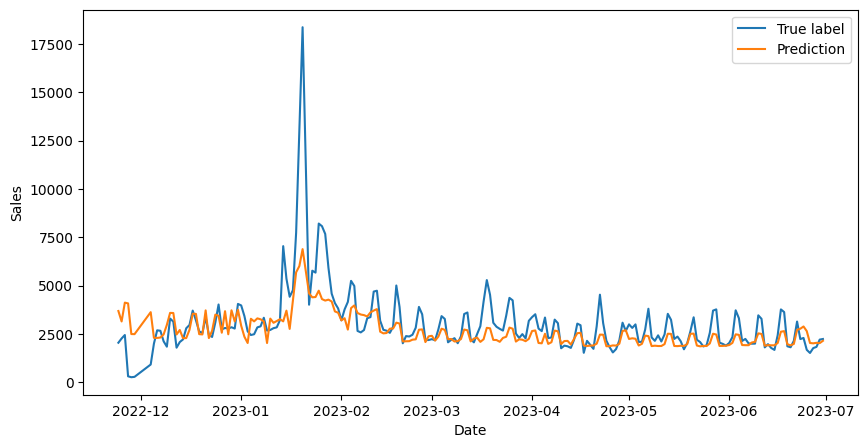

In [55]:
plot_prediction(df_test = df_test,
                y_pred = y_pred)

In [22]:
df_predict = df_test.reset_index().merge(pd.DataFrame(data = y_pred, columns = ['prediction']),
                                             how = 'left',
                                             left_index = True,
                                             right_index = True)
df_predict['Abs Error'] = abs(df_predict['Sales'] - df_predict['prediction'])
df_predict.sort_values(by = 'Abs Error', ascending = False).head()

,index,Category Code,Sales,Sales_365_daylag,Sales_364_daylag,is_holiday,Year,Month,Day,DayOfWeek,WeekNumber,Quarter,prediction,Abs Error
5458,5548,1011010504,6036.382812,657.947266,831.328125,0,2023,1,20,4,3,1,732.385620,5303.997192
5452,5542,1011010504,4398.406250,540.995117,657.947266,0,2023,1,19,3,3,1,732.385620,3666.020630
318,5544,1011010101,3911.250000,573.203125,597.609375,0,2023,1,20,4,3,1,625.118164,3286.131836
6743,5549,1011010801,3731.937500,593.210938,602.474609,0,2023,1,20,4,3,1,600.417603,3131.519897
6737,5543,1011010801,3173.509766,546.207031,593.210938,0,2023,1,19,3,3,1,397.046234,2776.463531
